In [1]:
%config InlineBackend.figure_format = "svg"

import time
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, plot_roc_curve, confusion_matrix

# Import data and create datasets

As labels dos dados estão definidas tais que:
- Background: 0
- Sinal: 1

In [2]:
# Gather data
bkgd = pd.read_hdf("Data/Background.h5", key='bkgd')
fcnc = pd.read_hdf("Data/FCNC.h5", key="fcnc")
X_train = pd.concat([bkgd, fcnc])
X_train

,Electron1_Eta,Electron1_PT,Electron1_Phi,Electron2_Eta,Electron2_PT,Electron2_Phi,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,...,Muon1_Eta,Muon1_PT,Muon1_Phi,Muon2_Eta,Muon2_PT,Muon2_Phi,Muon_Multi,ScalarHT_HT,gen_weights,Label
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.482720,158.952774,595.341003,...,0.443487,407.632080,-0.755916,0.785445,292.118774,2.734722,2,1212.756226,1.304437e-07,0
1,-2.060421,30.932735,-1.365277,0.000000,0.000000,0.000000,1,0.000000,0.000000,0.000000,...,-2.106180,54.675926,2.572098,0.000000,0.000000,0.000000,1,352.939209,1.304437e-07,0
2,-1.025947,40.282574,-1.773086,0.288352,26.201660,-0.694144,2,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,419.889740,1.304437e-07,0
3,1.084838,82.556099,2.932473,0.000000,0.000000,0.000000,1,0.969367,103.233589,318.344971,...,-0.059388,43.076065,-2.346566,0.000000,0.000000,0.000000,1,610.762146,1.304437e-07,0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,...,1.464516,80.244713,-2.605392,1.797688,23.799982,2.562366,2,291.874695,1.304437e-07,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496617,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,...,2.364251,79.450447,-2.115078,1.581713,46.098675,0.268987,2,306.712402,3.264224e-09,1
496618,-0.847799,214.928589,-2.360383,0.059395,31.239508,-2.978243,2,-0.959045,70.461861,257.986145,...,-1.299547,46.357815,-2.891009,0.000000,0.000000,0.000000,1,541.768921,3.264224e-09,1
496623,-0.230892,80.927383,-0.913889,0.000000,0.000000,0.000000,1,0.000000,0.000000,0.000000,...,-0.219239,120.608452,1.697549,0.000000,0.000000,0.000000,1,305.327148,3.264224e-09,1
496624,0.584297,143.974167,2.141792,0.000000,0.000000,0.000000,1,0.000000,0.000000,0.000000,...,-0.948717,27.718317,-0.361032,0.000000,0.000000,0.000000,1,404.741730,3.264224e-09,1


In [4]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_train.drop(columns="Label"), X_train["Label"], 
                                                    test_size=1/3, random_state=42)

In [6]:
print(f"Train_size: {len(y_train)} | Test_size: {len(y_test)}")

Train_size: 2960533 | Test_size: 1480267


In [10]:
# Get sample weights
train_weights = X_train["gen_weights"]
test_weights = X_test["gen_weights"]

# Get training features
X_train = X_train.drop(["gen_weights"], axis=1)

# Get testing features
X_test = X_test.drop(["gen_weights"], axis=1)

# Get class weights
# Class 0 (background) is the reference class, with weight 1
class_weights = {
    0: 1,
    1: len(y_train[y_train == 0]) / len(y_train[y_train == 1])
}

In [12]:
print(f"Class weights:\n{class_weights}\n")
print(f"Train_weights:\n{train_weights.values}\n")
print(f"Test_weights:\n{test_weights.values}\n")
print(f"X_train:\n{X_train.values}\n")
print(f"y_train:\n{y_train.values}\n")
print(f"X_test:\n{X_test.values}\n")
print(f"y_test:\n{y_test.values}\n")

Class weights:
{0: 1, 1: 21.714099386983175}

Train_weights:
[5.84247368e-07 2.45847956e-05 5.84247368e-07 ... 2.37461767e-05
 3.26422429e-09 2.45847956e-05]

Test_weights:
[5.84247368e-07 2.37461767e-05 2.37461767e-05 ... 5.84247368e-07
 2.45847956e-05 5.84247368e-07]

X_train:
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.43416023e+00
   2.00000000e+00  3.67212250e+02]
 [ 2.35044792e-01  6.95409927e+01  2.78545356e+00 ...  0.00000000e+00
   1.00000000e+00  3.25054840e+02]
 [-1.08409858e+00  2.43246975e+01 -2.79117322e+00 ...  0.00000000e+00
   1.00000000e+00  2.02325790e+02]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.72923017e+00
   2.00000000e+00  1.97660004e+02]
 [ 1.46371841e+00  3.39957458e+02  4.40391511e-01 ...  0.00000000e+00
   0.00000000e+00  1.05735388e+03]
 [ 5.15887201e-01  2.04379234e+01  2.43531656e+00 ...  0.00000000e+00
   1.00000000e+00  2.42583435e+02]]

y_train:
[0 0 0 ... 0 1 0]

X_test:
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+

In [14]:
print(f"X_train: {X_train.values.shape} | y_train: {y_train.values.shape} | train_weights: {train_weights.values.shape}")
print(f"X_test: {X_test.values.shape} | y_test: {y_test.values.shape} | test_weights: {test_weights.values.shape}")

X_train: (2960533, 69) | y_train: (2960533,) | train_weights: (2960533,)
X_test: (1480267, 69) | y_test: (1480267,) | test_weights: (1480267,)


# Build the model

In [16]:
class Standardization(keras.layers.Layer):
    def adapt(self, data_samples):
        self.means = np.mean(data_samples, axis=0, keepdims=True)
        self.stds = np.std(data_samples, axis=0, keepdims=True)
        
    def call(self, inputs):
        return (inputs - self.means) / (self.stds + keras.backend.epsilon())
    
std_layer = Standardization()
std_layer.adapt(X_train.values)

Tentar um modelo com menos complexidade e utilizar MC Dropout para tentar obter melhores resultados

In [28]:
inputs = keras.Input(shape=(69,))
standardize = std_layer(inputs)
fc1 = keras.layers.Dense(100, activation='relu')(inputs)
d1 = keras.layers.Dropout(0.1)(fc1, training=True)
fc2 = keras.layers.Dense(80, activation='relu')(d1)
d2 = keras.layers.Dropout(0.1)(fc2, training=True)
fc3 = keras.layers.Dense(60, activation='relu')(d2)
d3 = keras.layers.Dropout(0.1)(fc3, training=True)
fc4 = keras.layers.Dense(40, activation='relu')(d3)
outputs = keras.layers.Dense(1, activation='sigmoid')(fc4)

model = keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss="binary_crossentropy",
              metrics=["accuracy", keras.metrics.AUC()])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 69)]              0         
_________________________________________________________________
dense_10 (Dense)             (None, 90)                6300      
_________________________________________________________________
dropout_3 (Dropout)          (None, 90)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 120)               10920     
_________________________________________________________________
dropout_4 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 80)                9680      
_________________________________________________________________
dropout_5 (Dropout)          (None, 80)                0   

In [29]:
# Model name
name = str(time.time())

# Callbacks 

In [30]:
# Tensorboard
TB = keras.callbacks.TensorBoard("logs/" + name)

# Early Stopping
ES = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=2, mode="min")

# Model Checkpoint
MC = keras.callbacks.ModelCheckpoint("models/" + name + ".h5", save_best_only=True, monitor="val_loss",
                                     mode="min")

# Treinar modelo

O modelo tem uma AUC consideravelmente baixa

In [31]:
history = model.fit(X_train.values, y_train.values, batch_size=1024,
                    epochs=10, validation_split=0.5, shuffle=True,
                    sample_weight=train_weights.values, class_weight=class_weights,
                    callbacks=[TB, ES, MC])

Epoch 1/10
1446/1446 [==============================] - 93s 64ms/step - loss: 1.6547e-06 - accuracy: 0.9551 - auc_2: 0.4997 - val_loss: 1.1860e-08 - val_accuracy: 0.9557 - val_auc_2: 0.4996
Epoch 2/10
1446/1446 [==============================] - 92s 64ms/step - loss: 1.1817e-07 - accuracy: 0.9562 - auc_2: 0.5000 - val_loss: 2.5054e-08 - val_accuracy: 0.9557 - val_auc_2: 0.5017
Epoch 3/10
1446/1446 [==============================] - 92s 64ms/step - loss: 1.1420e-07 - accuracy: 0.9562 - auc_2: 0.5018 - val_loss: 1.4550e-08 - val_accuracy: 0.9557 - val_auc_2: 0.5041
Epoch 4/10
1446/1446 [==============================] - 92s 64ms/step - loss: 7.4858e-08 - accuracy: 0.9562 - auc_2: 0.5050 - val_loss: 1.2241e-08 - val_accuracy: 0.9557 - val_auc_2: 0.5093
Epoch 5/10
1446/1446 [==============================] - 92s 64ms/step - loss: 6.2559e-08 - accuracy: 0.9562 - auc_2: 0.5097 - val_loss: 1.2474e-08 - val_accuracy: 0.9557 - val_auc_2: 0.5152
Epoch 6/10
1446/1446 [============================

# Tests and predictions

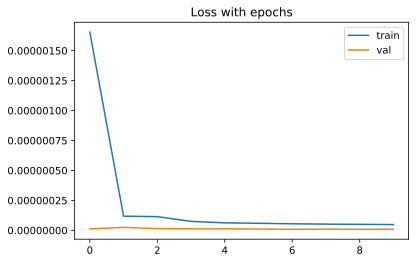

In [35]:
plt.title("Loss with epochs")
plt.plot(history.history["loss"], label='train')
plt.plot(history.history["val_loss"], label='val')
plt.legend()
plt.show()

In [36]:
y_preds = model.predict(X_test.values, batch_size=1024).reshape(-1)

In [37]:
accuracy_score(y_test.values, y_preds.round())

0.9558302657561102

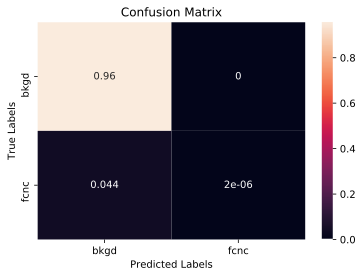

In [38]:
cm = confusion_matrix(y_test.values, y_preds.round(), normalize="all")

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.xaxis.set_ticklabels(["bkgd", "fcnc"])
ax.yaxis.set_ticklabels(["bkgd", "fcnc"])
plt.show()

# Monte Carlo Dropout

In [40]:
num_preds = 100
mcpreds = []

for _ in tqdm(range(num_preds), total=num_preds, desc="MCDropout"):
    mcpreds.append(model.predict(X_test.values, batch_size=1024).reshape(-1))

MCDropout: 100%|██████████| 100/100 [09:52<00:00,  5.93s/it]


In [43]:
mcpreds = np.array(mcpreds).mean(axis=0).round()

In [49]:
accuracy_score(y_test.values, mcpreds)

0.9558282390947038

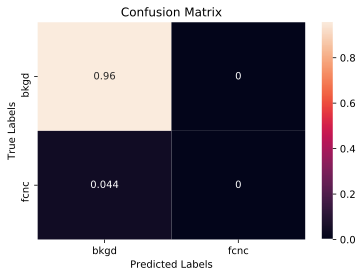

In [50]:
cm = confusion_matrix(y_test.values, mcpreds, normalize="all")

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.xaxis.set_ticklabels(["bkgd", "fcnc"])
ax.yaxis.set_ticklabels(["bkgd", "fcnc"])
plt.show()